In [2]:
from google.colab import drive

# Check if drive is already mounted
import os
if not os.path.exists('/content/drive'):
  drive.mount('/content/drive', force_remount=True)
else:
  print("Drive already mounted.")
%cd /content/drive/My Drive/[2024-2025] AN2DL/Homework 1

Drive already mounted.
/content/drive/My Drive/[2024-2025] AN2DL/Homework 1


In [3]:
import numpy as np
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

from imblearn.over_sampling import SMOTE

np.random.seed(42)
tf.random.set_seed(42);
import pandas as pd

import random
import matplotlib.pyplot as plt
seed = 42

In [4]:
import numpy as np

data = np.load('training_set.npz')
x = data['images']
y = data['labels']

print("Dimensioni originali del dataset:", x.shape, y.shape)

# Calcola l'hash di ogni immagine
hashes = [hash(tuple(image.flatten())) for image in x]

# Trova gli indici dei duplicati
unique_indices = np.unique(hashes, return_index=True)[1]

# Estrai le immagini e le labels univoche
x = x[unique_indices]
y = y[unique_indices]

# Stampa le dimensioni del dataset dopo la rimozione dei duplicati
print("Dimensioni del dataset dopo la rimozione dei duplicati:", x.shape, y.shape)


#stampa delle occorrenze per ogni classe prima di qualsiasi ritocco
print('Counting occurrences of target classes:')
print(pd.DataFrame(y, columns=['digit'])['digit'].value_counts())

#sampling dei dati per equiparare le classi
smote = SMOTE(random_state = 42)
x_resampled, y_resampled = smote.fit_resample(x.reshape(x.shape[0], -1), y)
x_resampled = x_resampled.reshape(-1,*x.shape[1:])

#normalizzazione
x_normalized = (x_resampled / 255).astype('float32')

print('\nCounting occurrences of target classes after SMOTE:')
print(pd.DataFrame(y_resampled, columns=['digit'])['digit'].value_counts())


#Convert labels to categorical format using one-hot encoding
y_resampled_encoded = tfk.utils.to_categorical(y_resampled)

x_train, x_val, y_train, y_val= train_test_split(x_resampled, y_resampled_encoded, test_size=0.1, random_state=seed, stratify=y_resampled)
# Define a mapping of labels to their corresponding digit names
labels = {0:'Basophil', 1:'Eosinophil', 2:'Erythroblast', 3:'Immature granulocytes', 4:'Lymphocyte', 5:'Monocyte', 6:'Neutrophil', 7:'Platelet'}

# Save unique labels
unique_labels = list(labels.values())
#Print the shapes of the loaded datasets
print("Training Data Shape:", x_train.shape)  # (numero di esempi, altezza immagine, larghezza immagine, canali colore)
print("Training Label Shape:", y_train.shape) # (numero di esempi, numero di classi)
print("Validation Data Shape:", x_val.shape)
print("Validation Label Shape:", y_val.shape)

Dimensioni originali del dataset: (13759, 96, 96, 3) (13759, 1)
Dimensioni del dataset dopo la rimozione dei duplicati: (11953, 96, 96, 3) (11953, 1)
Counting occurrences of target classes:
digit
6    2330
1    2179
3    2023
7    1643
2    1085
5     993
0     851
4     849
Name: count, dtype: int64

Counting occurrences of target classes after SMOTE:
digit
7    2330
0    2330
5    2330
3    2330
6    2330
2    2330
1    2330
4    2330
Name: count, dtype: int64
Training Data Shape: (16776, 96, 96, 3)
Training Label Shape: (16776, 8)
Validation Data Shape: (1864, 96, 96, 3)
Validation Label Shape: (1864, 8)


In [5]:
# Compare categorical label and "default" label representation
# Display the categorical label
print('Categorical label:', y_train[0])
# Display the equivalent numeric label
print('"Default" label:', np.argmax(y_train[0]))

Categorical label: [0. 0. 0. 1. 0. 0. 0. 0.]
"Default" label: 3


In [6]:
# Input shape for the model
input_shape = x_train.shape[1:]

# Output shape for the model
output_shape = y_train.shape[1]

print("Input Shape:", input_shape)
print("Output Shape:", output_shape)

# Number of training epochs
epochs = 75

# Batch size for training
batch_size = 128

# Learning rate: step size for updating the model's weights
learning_rate = 0.001

# Print the defined parameters
print("Epochs:", epochs)
print("Batch Size:", batch_size)
print("Learning Rare:", learning_rate)

Input Shape: (96, 96, 3)
Output Shape: 8
Epochs: 75
Batch Size: 128
Learning Rare: 0.001


In [7]:
#AUGUMENTATION

datagen = ImageDataGenerator(
    rotation_range=360,  # Ruota le immagini di un angolo casuale tra 0 e 360 gradi
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range= (0.8, 1.2)
)


In [12]:
def build_model(input_shape, output_shape):
    # Define the input layer
    input_layer = tfkl.Input(shape=input_shape, name='input_layer')

    # Feature extraction layers
    cnn = tfkl.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same')(input_layer)
    cnn = tfkl.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same')(cnn)
    cnn = tfkl.MaxPooling2D()(cnn)
    cnn = tfkl.Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same')(cnn)
    cnn = tfkl.Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same')(cnn)
    cnn = tfkl.MaxPooling2D()(cnn)
    cnn = tfkl.Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same')(cnn)
    cnn = tfkl.Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same')(cnn)
    cnn = tfkl.MaxPooling2D()(cnn)
    cnn = tfkl.Conv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same')(cnn)
    cnn = tfkl.MaxPooling2D()(cnn)
    cnn = tfkl.Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding='same')(cnn)


 # Flatten layer
    flatten = tfkl.Flatten()(cnn)

    # Dense layers
    dense = tfkl.Dense(units=64, activation='relu')(flatten)
    dense = tfkl.Dropout(0.5)(dense)  # Aggiunto Dropout per regolarizzazione
    dense = tfkl.Dense(units=32, activation='relu')(dense)

    # Output layer
    output_layer = tfkl.Dense(units=output_shape, activation='softmax')(dense)

    # Create the model
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='cnn_model')

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(learning_rate), metrics=['accuracy'])

    return model


# Build the classifier model
model = build_model(input_shape, output_shape)







In [13]:
# Display a summary of the model architecture
model.summary(expand_nested=True, show_trainable=True)

# Plot the model architecture
# tfk.utils.plot_model(model, expand_nested=True, show_trainable=True, show_shapes=True, dpi=70)

Model: "cnn_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━┓
┃ Layer (type)                        ┃ Output Shape                 ┃       Param # ┃ Traina… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━┩
│ input_layer (InputLayer)            │ (None, 96, 96, 3)            │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ conv2d_18 (Conv2D)                  │ (None, 96, 96, 32)           │           896 │    Y    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ conv2d_19 (Conv2D)                  │ (None, 96, 96, 32)           │         9,248 │    Y    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ max_pooling2d_9 (MaxPooling2D)      │ (None, 48, 48, 32)           │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ conv2d_20 (Conv2D)                  │ (None, 48, 48, 64)           │        18,496 │    Y    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ conv2d_21 (Conv2D)                  │ (None, 48, 48, 64)           │        36,928 │    Y    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ max_pooling2d_10 (MaxPooling2D)     │ (None, 24, 24, 64)           │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ conv2d_22 (Conv2D)                  │ (None, 24, 24, 128)          │        73,856 │    Y    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ conv2d_23 (Conv2D)                  │ (None, 24, 24, 128)          │       147,584 │    Y    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ max_pooling2d_11 (MaxPooling2D)     │ (None, 12, 12, 128)          │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ conv2d_24 (Conv2D)                  │ (None, 12, 12, 256)          │       295,168 │    Y    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ max_pooling2d_12 (MaxPooling2D)     │ (None, 6, 6, 256)            │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ conv2d_25 (Conv2D)                  │ (None, 6, 6, 512)            │     1,180,160 │    Y    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ flatten_2 (Flatten)                 │ (None, 18432)                │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ dense_6 (Dense)                     │ (None, 64)                   │     1,179,712 │    Y    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ dropout_2 (Dropout)                 │ (None, 64)                   │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ dense_7 (Dense)                     │ (None, 32)                   │         2,080 │    Y    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ dense_8 (Dense)                     │ (None, 8)                    │           264 │    Y    │
└─────────────────────────────────────┴──────────────────────────────┴───────────────┴─────────┘

 Total params: 2,944,392 (11.23 MB)

 Trainable params: 2,944,392 (11.23 MB)

 Non-trainable params: 0 (0.00 B)

In [14]:
# Define the patience value for early stopping
patience = 10

# Create an EarlyStopping callback
early_stopping = tfk.callbacks.EarlyStopping(
    monitor='val_accuracy',
    mode='max',
    patience=patience,
    restore_best_weights=True
)

# Store the callback in a list
callbacks = [early_stopping]


#generatore di immagini agumentate
train_generator = datagen.flow(x_train, y_train, batch_size=batch_size)


# Train the model with early stopping callback
# Train the model using the data generator
history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=(x_val, y_val),  # Validation data remains the same
    callbacks=callbacks
).history



# Calculate and print the final validation accuracy
final_val_accuracy = round(history['val_accuracy'][-1]* 100, 2)
print(f'Final validation accuracy: {final_val_accuracy}%')

model.save('weights.keras')
del model

Epoch 1/75
132/132 ━━━━━━━━━━━━━━━━━━━━ 70s 464ms/step - accuracy: 0.1303 - loss: 2.7176 - val_accuracy: 0.1765 - val_loss: 1.9597
Epoch 2/75
132/132 ━━━━━━━━━━━━━━━━━━━━ 59s 429ms/step - accuracy: 0.1855 - loss: 2.0054 - val_accuracy: 0.2645 - val_loss: 1.8194
Epoch 3/75
132/132 ━━━━━━━━━━━━━━━━━━━━ 59s 428ms/step - accuracy: 0.2143 - loss: 1.9005 - val_accuracy: 0.2511 - val_loss: 1.8374
Epoch 4/75
132/132 ━━━━━━━━━━━━━━━━━━━━ 81s 422ms/step - accuracy: 0.2375 - loss: 1.8350 - val_accuracy: 0.3906 - val_loss: 1.6029
Epoch 5/75
132/132 ━━━━━━━━━━━━━━━━━━━━ 82s 415ms/step - accuracy: 0.3108 - loss: 1.6079 - val_accuracy: 0.4850 - val_loss: 1.3242
Epoch 6/75
132/132 ━━━━━━━━━━━━━━━━━━━━ 82s 410ms/step - accuracy: 0.3792 - loss: 1.4492 - val_accuracy: 0.5370 - val_loss: 1.1474
Epoch 7/75
132/132 ━━━━━━━━━━━━━━━━━━━━ 58s 413ms/step - accuracy: 0.4424 - loss: 1.3105 - val_accuracy: 0.5435 - val_loss: 1.1466
Epoch 8/75
132/132 ━━━━━━━━━━━━━━━━━━━━ 59s 424ms/step - accuracy: 0.4940 - loss: 1

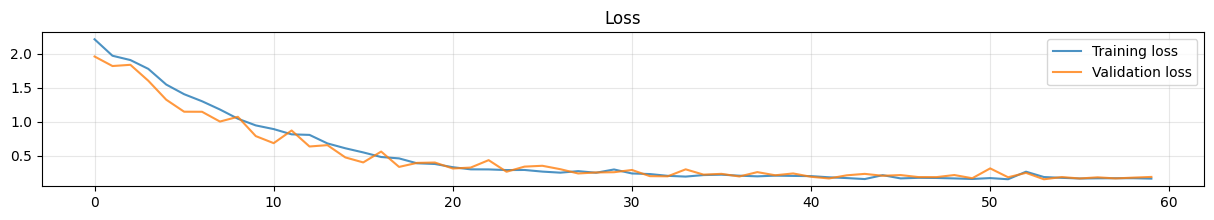

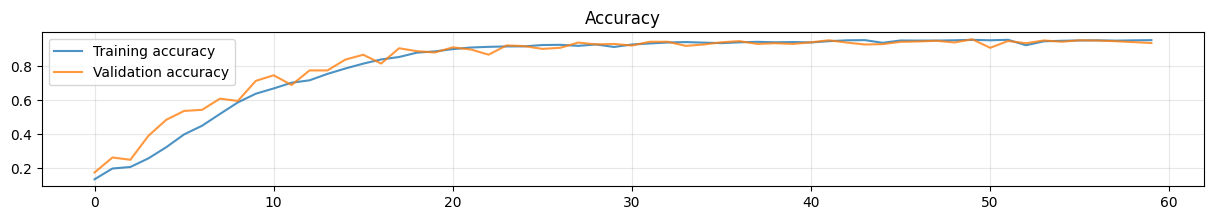

In [15]:
# Plot training and validation loss
plt.figure(figsize=(15, 2))
plt.plot(history['loss'], label='Training loss', alpha=.8)
plt.plot(history['val_loss'], label='Validation loss', alpha=.8)
plt.title('Loss')
plt.legend()
plt.grid(alpha=.3)

# Plot training and validation accuracy
plt.figure(figsize=(15, 2))
plt.plot(history['accuracy'], label='Training accuracy', alpha=.8)
plt.plot(history['val_accuracy'], label='Validation accuracy', alpha=.8)
plt.title('Accuracy')
plt.legend()
plt.grid(alpha=.3)
plt.show()

In [16]:
%%writefile model.py
import numpy as np

import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl


class Model:
    def __init__(self):
        """
        Initialize the internal state of the model. Note that the __init__
        method cannot accept any arguments.

        The following is an example loading the weights of a pre-trained
        model.
        """
        self.neural_network = tfk.models.load_model('weights.keras')

    def predict(self, X):
        """
        Predict the labels corresponding to the input X. Note that X is a numpy
        array of shape (n_samples, 96, 96, 3) and the output should be a numpy
        array of shape (n_samples,). Therefore, outputs must no be one-hot
        encoded.

        The following is an example of a prediction from the pre-trained model
        loaded in the __init__ method.
        """
        preds = self.neural_network.predict(X)
        if len(preds.shape) == 2:
            preds = np.argmax(preds, axis=1)
        return preds

Overwriting model.py


In [17]:
from datetime import datetime
filename = f'submission_{datetime.now().strftime("%y%m%d_%H%M%S")}.zip'

# Add files to the zip command if needed
!zip {filename} model.py weights.keras

from google.colab import files
files.download(filename)

  adding: model.py (deflated 56%)
  adding: weights.keras (deflated 20%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>